In [4]:
""" 
@Author: SHAO Nuoya 
@Date: 2021-12-05 00:25:19 
@Last Modified by: SHAO Nuoya 
@Last Modified time: 2021-12-05 00:25:19 
"""

' \n@Author: SHAO Nuoya \n@Date: 2021-12-05 00:25:19 \n@Last Modified by: SHAO Nuoya \n@Last Modified time: 2021-12-05 00:25:19 \n'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters
class BS:
    def __init__(self,
                 K=100,
                 S_min=0,
                 S_max=200,
                 T=1,
                 sigma=0.2,
                 r=0.1,
                 N=10,
                 I=10):
        self.K = K
        self.S_min = S_min
        self.S_max = S_max
        self.T = T
        self.sigma = sigma
        self.r = r
        self.N = N
        self.I = I

        self.h = (S_max - S_min) / I
        self.dt = T / N

        self.S = np.linspace(S_min, S_max, I).reshape(-1, 1)
        self.Sval = np.mean(self.S)
        self.alpha = sigma**2 * self.S**2 / (2 * self.h**2)
        self.beta = r * self.S / (2 * self.h)

    def get_A(self) -> np.ndarray:
        I = self.I
        A = np.zeros((I, I))
        for i in range(I):
            A[i, i] = 2 * self.alpha[i] + self.r

        for i in range(I - 1):
            A[i + 1, i] = -self.alpha[i + 1] + self.beta[i + 1]
            A[i, i + 1] = -self.alpha[i] - self.beta[i]
        return A

    # Boundary condition
    def phi(self) -> np.ndarray:
        return np.maximum(self.K - self.S, 0).reshape(self.I, 1)

    def uleft(self, U: np.ndarray) -> float:
        return (-self.alpha[0] + self.beta[0]) * U[0]

    def uright(self, U: np.ndarray) -> float:
        return (-self.alpha[-1] - self.beta[-1]) * U[-1]

    def get_price(self, method: str) -> np.ndarray:
        U = np.array(self.phi())
        q = np.zeros((self.I, 1))
        A = self.get_A()
        for t in range(self.N):
            q[0] = self.uleft(U)
            q[-1] = self.uright(U)
            if method == 'EE':
                U = (np.eye(self.I) - self.dt * A) @ U - self.dt * q
            if method == 'IE':
                U = np.linalg.solve(A + np.eye(self.I) / self.dt,
                                    np.eye(self.I) / self.dt @ U - q)
            if method == 'CN':
                U = np.linalg.solve(A / 2 + np.eye(self.I) / self.dt,
                                    (-A / 2 + np.eye(self.I) / self.dt) @ U -
                                    q)

        return U

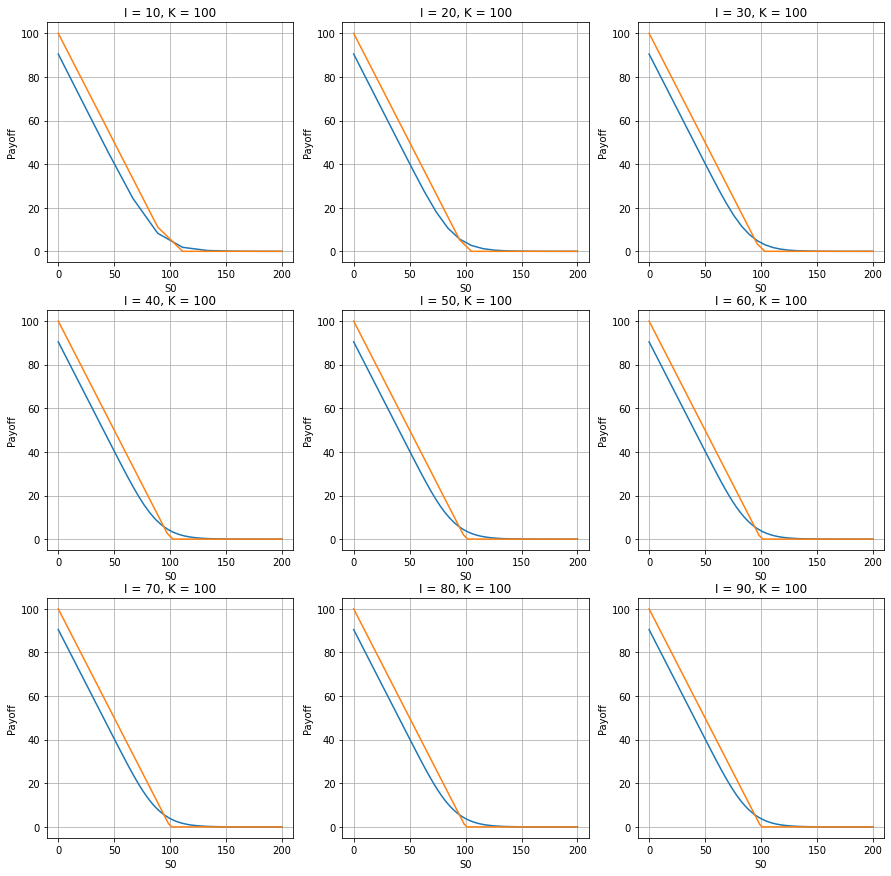

In [3]:
plt.figure(figsize=(15, 15))
for i in range(3):
    for j in range(3):
        index = i * 3 + j + 1
        I = 10 * index
        bs = BS(I=I)
        U = bs.get_price(method='CN')
        plt.subplot(3, 3, index)
        plt.plot(bs.S, U)
        plt.plot(bs.S, bs.phi())
        plt.title('I = {}, K = {}'.format(I, bs.K))
        plt.xlabel('S0')
        plt.ylabel('Payoff')
        plt.grid()